In [1]:
%load_ext autoreload
%autoreload 2

import math
import pandas as pd
import seaborn as sns
import warnings
%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 1000)
import numpy as np
import pandas as pd
import matplotlib.transforms as transforms
import re
from sklearn.cluster import DBSCAN
from statsmodels.nonparametric.smoothers_lowess import lowess


from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import datetime
import statsmodels

# Local Modules
import sys
import os.path
sys.path.insert(0, os.path.abspath('/scratch/horta/coronawiki/'))
from helpers.load import load_interventions, load_aggregated, load_topics
from helpers.vars import codes, helper_langs, interventions_helper, topics, codes
from helpers.plot import set_size, plot_dates, plot_interventions
from helpers.topics import order_topics, colors_z, get_df_pageviews_topics
from helpers.diffs_n_diffs import get_standard_error_sum
from dateutil.relativedelta import relativedelta

In [2]:
# Latex Configuration
import matplotlib.font_manager as font_manager
from matplotlib.lines import Line2D
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os
# fontpath = os.path.expanduser('~/LinLibertine_DRah.ttf')
# prop = font_manager.FontProperties(fname=fontpath)

params = {
    "axes.titlesize" : 14,
    'axes.labelsize': 12,
    'font.size': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
#     'font.family': 'Linux Libertine Display',
    'text.usetex': False
}

mpl.rcParams.update(params)

In [3]:
interventions = load_interventions("../data/interventions.csv")
topics_df, topics = load_topics('../data/topics_linked.csv.xz')
agg = load_aggregated("../data/aggregated_timeseries.json.gz")
codes_order = ["sr", "it", "fr", "en", "nl", "ko", "de", "fi", "ja", "no", "sv", "da"]
time_int = 35

In [5]:
topics_df.head()

,index,Geography.Regions.Asia.Central Asia,Geography.Regions.Europe.Eastern Europe,History and Society.Military and warfare,Culture.Media.Television,History and Society.Education,Culture.Media.Books,Geography.Regions.Africa.Africa*,Culture.Visual arts.Architecture,Culture.Biography.Women,Geography.Regions.Americas.North America,STEM.STEM*,Culture.Performing arts,Culture.Literature,History and Society.Politics and government,Geography.Regions.Africa.Northern Africa,STEM.Earth and environment,Geography.Regions.Africa.Central Africa,STEM.Medicine & Health,STEM.Libraries & Information,Geography.Regions.Europe.Europe*,Geography.Regions.Europe.Western Europe,Culture.Media.Radio,STEM.Space,Culture.Visual arts.Comics and Anime,STEM.Technology,Culture.Internet culture,Culture.Media.Software,Geography.Regions.Asia.East Asia,Geography.Regions.Europe.Southern Europe,STEM.Biology,Culture.Food and drink,History and Society.Business and economics,Culture.Visual arts.Fashion,Geography.Regions.Americas.Central America,Geography.Geographical,Geography.Regions.Oceania,STEM.Physics,Culture.Media.Films,Geography.Regions.Asia.South Asia,History and Society.Transportation,History and Society.History,Geography.Regions.Africa.Western Africa,Culture.Media.Media*,Geography.Regions.Americas.South America,Culture.Linguistics,STEM.Computing,Culture.Biography.Biography*,Culture.Philosophy and religion,Culture.Sports,Geography.Regions.Africa.Southern Africa,Culture.Visual arts.Visual arts*,Geography.Regions.Africa.Eastern Africa,History and Society.Society,STEM.Engineering,STEM.Mathematics,Geography.Regions.Asia.West Asia,STEM.Chemistry,Geography.Regions.Europe.Northern Europe,Culture.Media.Video games,Geography.Regions.Asia.Southeast Asia,Culture.Media.Entertainment,Culture.Media.Music,Geography.Regions.Asia.Asia*,Geography.Regions.Asia.North Asia,qid
0,Rosmalen,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Q2001490
1,Commelinales,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Q290349
2,Transport_in_Honduras,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Q1130638
3,QuakeC,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Q2122062
4,Food_writing,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Q5465542


In [12]:
# df = pd.DataFrame.from_dict(agg)
# df.head()
topics

['Culture.Biography.Biography*',
 'Culture.Biography.Women',
 'Culture.Food and drink',
 'Culture.Internet culture',
 'Culture.Linguistics',
 'Culture.Literature',
 'Culture.Media.Books',
 'Culture.Media.Entertainment',
 'Culture.Media.Films',
 'Culture.Media.Media*',
 'Culture.Media.Music',
 'Culture.Media.Radio',
 'Culture.Media.Software',
 'Culture.Media.Television',
 'Culture.Media.Video games',
 'Culture.Performing arts',
 'Culture.Philosophy and religion',
 'Culture.Sports',
 'Culture.Visual arts.Architecture',
 'Culture.Visual arts.Comics and Anime',
 'Culture.Visual arts.Fashion',
 'Culture.Visual arts.Visual arts*',
 'Geography.Geographical',
 'Geography.Regions.Africa.Africa*',
 'Geography.Regions.Africa.Central Africa',
 'Geography.Regions.Africa.Eastern Africa',
 'Geography.Regions.Africa.Northern Africa',
 'Geography.Regions.Africa.Southern Africa',
 'Geography.Regions.Africa.Western Africa',
 'Geography.Regions.Americas.Central America',
 'Geography.Regions.Americas.North

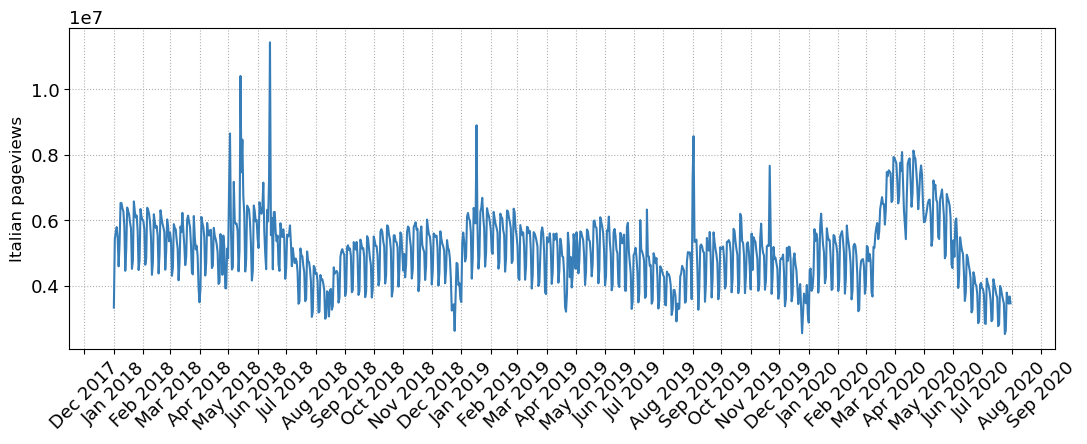

In [6]:
import matplotlib.dates as mdates
italy = agg['it']['sum']
# italy = italy[(italy.index.year == 2020) & (italy.index.month <= 12) & (italy.index.month >= 1)]
fig = plt.figure(constrained_layout=False, figsize=(28,10))
gs = fig.add_gridspec(2, 2, hspace=0.4)
ax = fig.add_subplot(gs[0, 0])

ax.plot(italy.index , italy.values, color="#377eb8", zorder=9)

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.setp(ax.get_xticklabels(), rotation=45)

ax.set_ylabel("Italian pageviews")

ax.grid(ls=":")

In [126]:
agg.keys()

dict_keys(['ja.m', 'it', 'da.m', 'tr', 'no.m', 'en', 'sr', 'tr.m', 'en.m', 'no', 'sv', 'nl.m', 'nl', 'da', 'de', 'fr.m', 'ca.m', 'de.m', 'ko.m', 'fi.m', 'sr.m', 'ja', 'fr', 'fi', 'ca', 'it.m', 'sv.m', 'ko'])

Dominant frequencies in the dataset and the amplitude is their power:

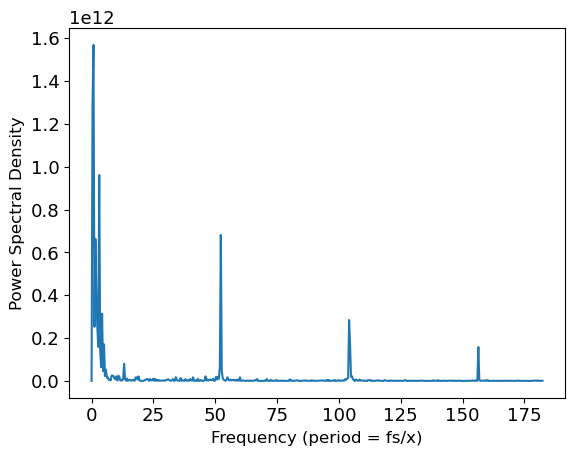

In [7]:
from scipy.signal import periodogram

italy = agg['it.m']['sum']
numeric_values = italy.values 

freq, spectrum = periodogram(numeric_values, fs=365)
plt.plot(freq,spectrum)
plt.xlabel('Frequency (period = fs/x)')
plt.ylabel('Power Spectral Density')
plt.show()

# There are some weekly patterns -> peak at fs/52 = 7: weekly peak

Calculate the number of times each topic has been consulted (over the whole time period):

In [8]:
def sum_topics(datadict, country):
    topics_country = datadict[country]['topics']
    
    sums_list = []
    
    for i, topic in enumerate(topics):
        topic_data = topics_country[topics[i]]['sum']
        topic_values = topic_data.values
        total_sum = np.sum(topic_values)
        sums_list.append((topics[i], total_sum))
        total_sum = 0
        
    return sums_list

Plots of the 'popularity' of each topic for specific countries:

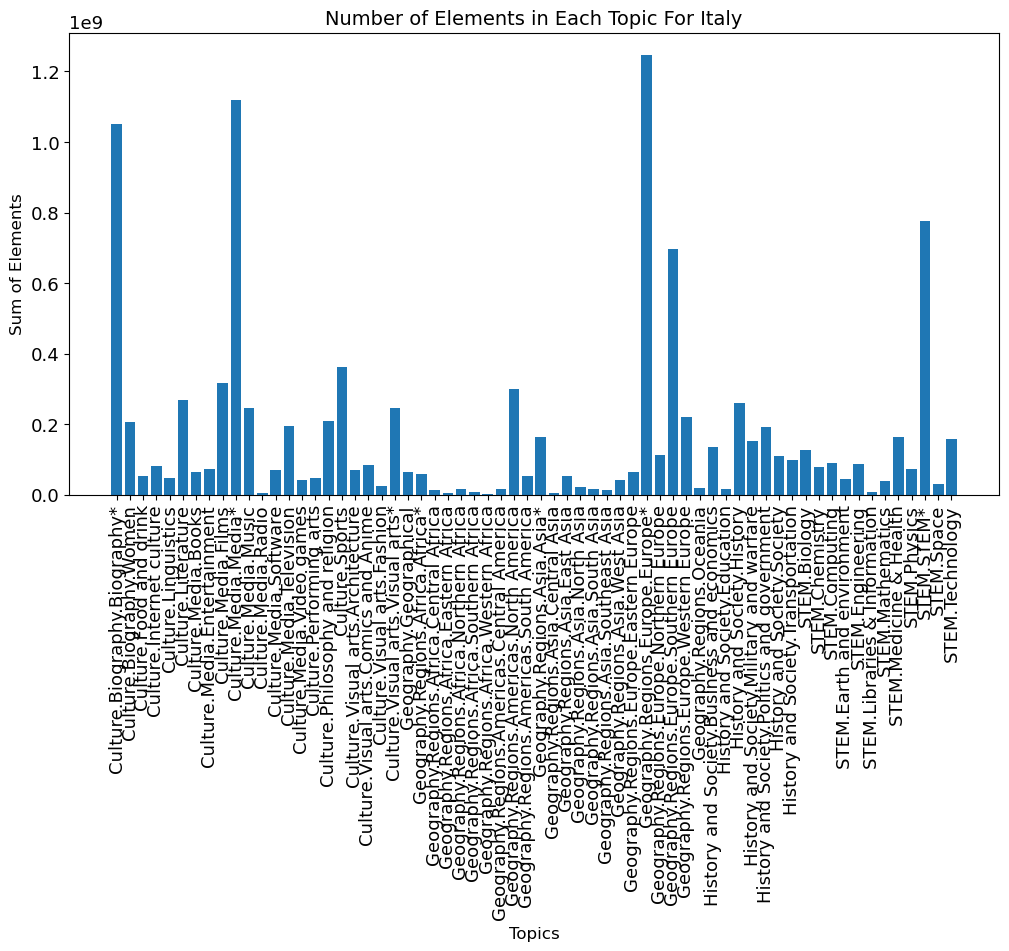

In [9]:
sums_list = sum_topics(agg, 'it')

topics = [item[0] for item in sums_list]
sums = [item[1] for item in sums_list]

plt.figure(figsize=(12, 6))
plt.bar(topics, sums)
plt.xticks(rotation=90)
plt.xlabel('Topics')
plt.ylabel('Sum of Elements')
plt.title('Number of Elements in Each Topic For Italy')
plt.show()

[('Culture.Biography.Biography*', 318124933), ('Culture.Biography.Women', 63147129), ('Culture.Food and drink', 33752051), ('Culture.Internet culture', 24007855), ('Culture.Linguistics', 24851190), ('Culture.Literature', 56971184), ('Culture.Media.Books', 13818274), ('Culture.Media.Entertainment', 15492228), ('Culture.Media.Films', 40295092), ('Culture.Media.Media*', 243792516), ('Culture.Media.Music', 80791377), ('Culture.Media.Radio', 2567981), ('Culture.Media.Software', 25871800), ('Culture.Media.Television', 31357840), ('Culture.Media.Video games', 8894416), ('Culture.Performing arts', 10580166), ('Culture.Philosophy and religion', 76361784), ('Culture.Sports', 105410096), ('Culture.Visual arts.Architecture', 23741130), ('Culture.Visual arts.Comics and Anime', 8743869), ('Culture.Visual arts.Fashion', 8665443), ('Culture.Visual arts.Visual arts*', 62554491), ('Geography.Geographical', 38087741), ('Geography.Regions.Africa.Africa*', 28498480), ('Geography.Regions.Africa.Central Afri

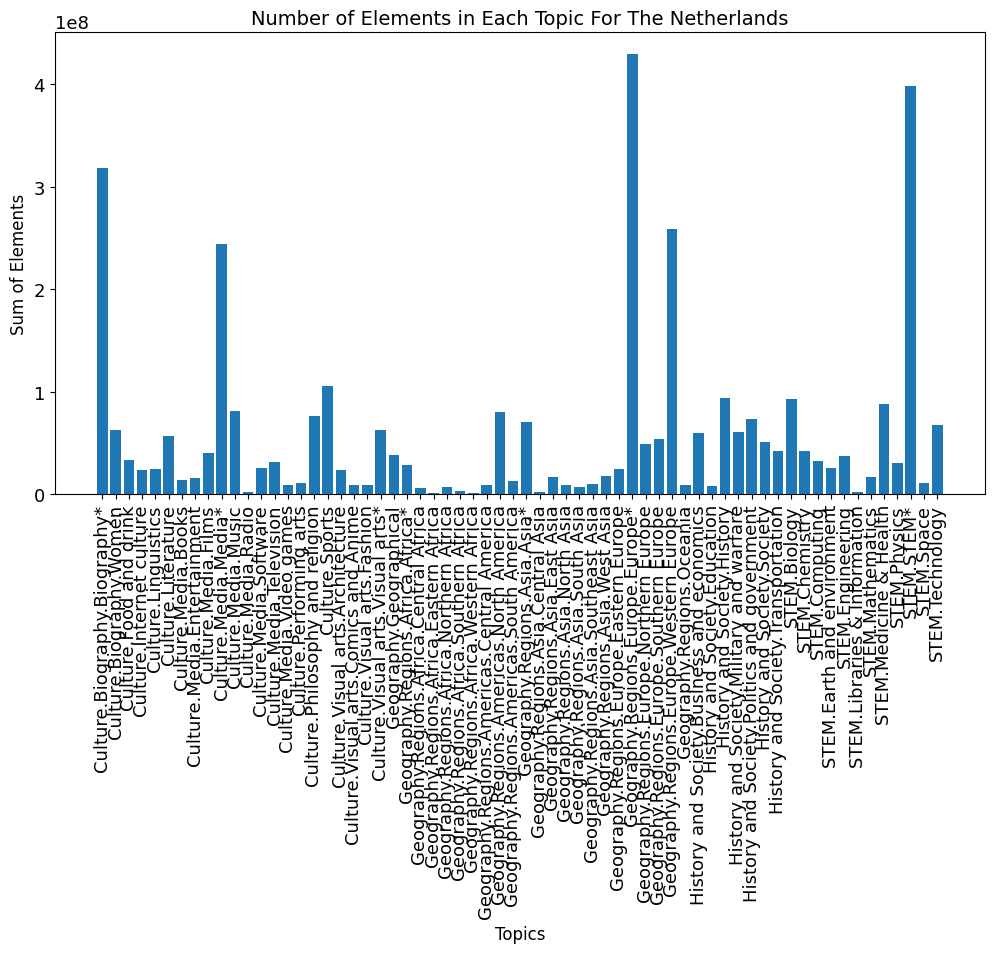

In [13]:
sums_list = sum_topics(agg, 'nl')

print(sums_list)

topics = [item[0] for item in sums_list]
sums = [item[1] for item in sums_list]

plt.figure(figsize=(12, 6))
plt.bar(topics, sums)
plt.xticks(rotation=90)
plt.xlabel('Topics')
plt.ylabel('Sum of Elements')
plt.title('Number of Elements in Each Topic For The Netherlands')
plt.show()

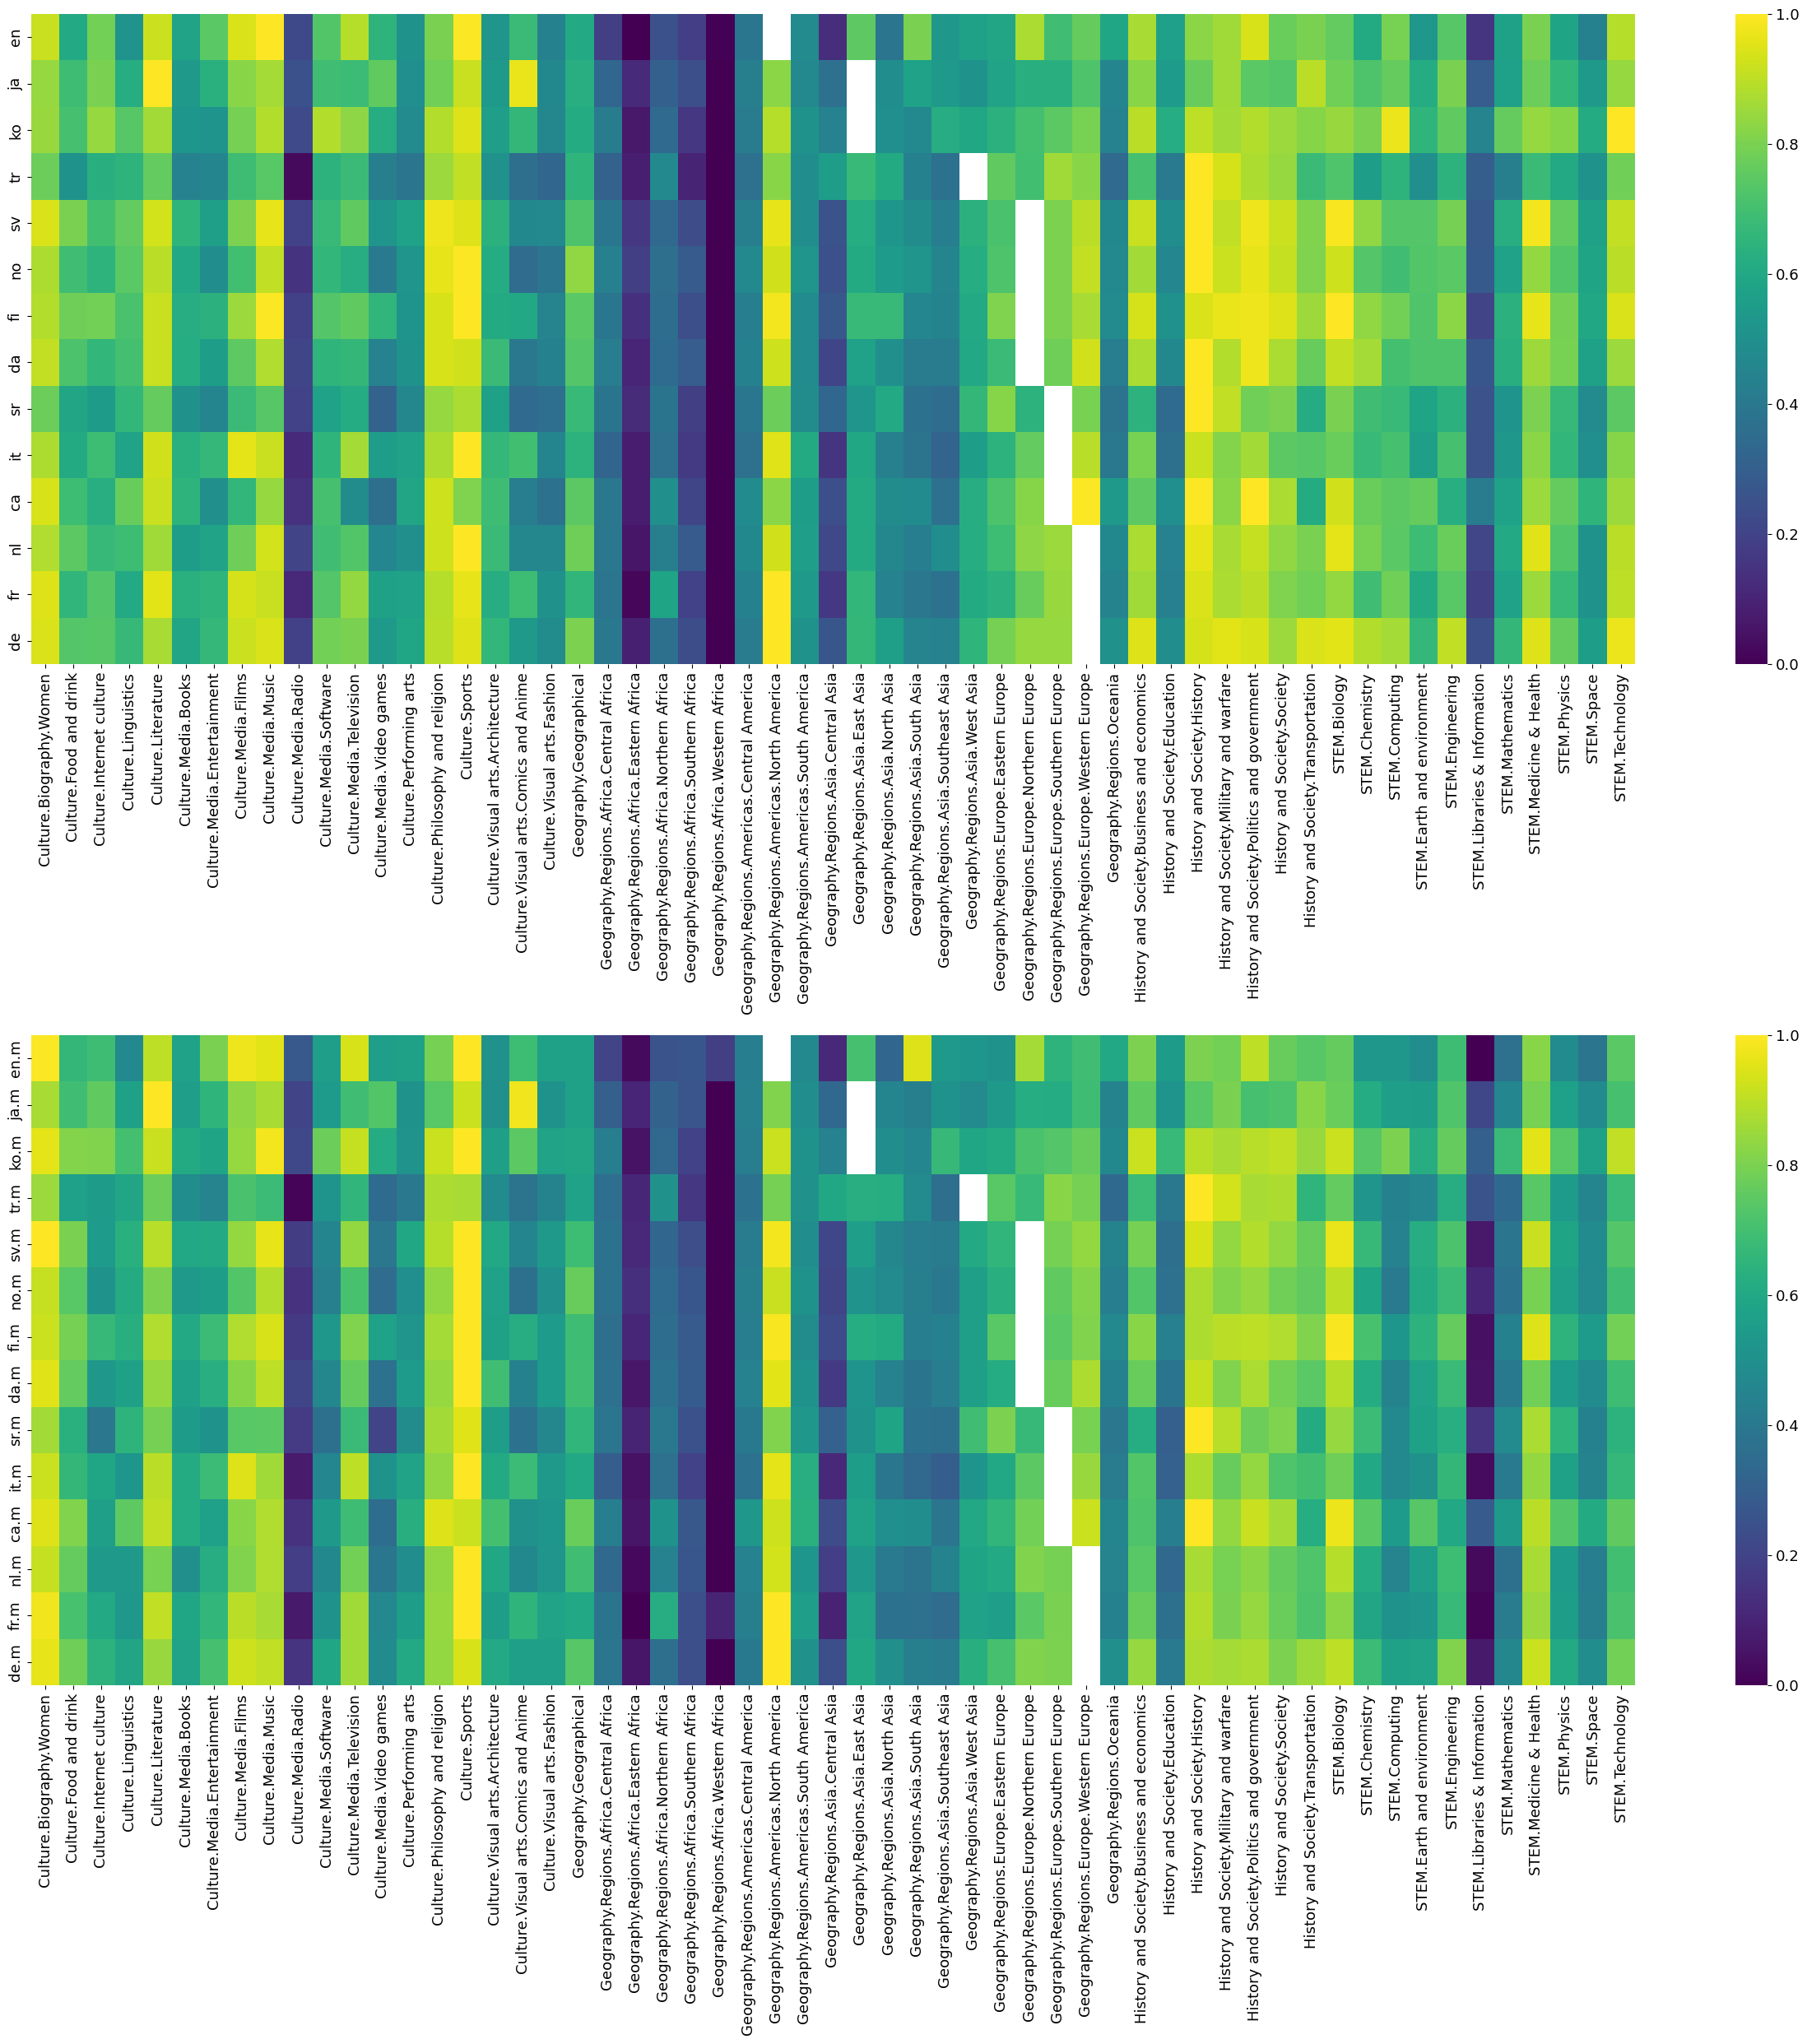

In [45]:
# Heatmap to show countries against topics chart
topics_dict = {}
lang_codes = ["en", "ja", "ko", "tr", "sv" , "no", "fi", "da", "sr", "it" , "ca", "nl", "fr", "de"]
ctr_codes = ["USA", "JPN", "KOR", "TUR", "SWE", "NOR", "FIN", "DEN", "SER", "ITA", "SPA", "NET", "FRA", "GER"]
code_dict = dict(zip(ctr_codes, lang_codes))
country_group = {'East Asia': ['ja', 'ko'], 'West Asia': ['tr'], 'Northern Europe': ['sv', 'no', 'fi', 'da'],
        'Southern Europe': ['sr', 'it', 'ca'], 'Western Europe':['nl', 'fr', 'de'], 'North America': ['en']}

codes = lang_codes + [c + '.m' for c in lang_codes]
for key in codes:
    topics_dict[key] = {}
    for topic in agg[key]['topics']:
        if topic[-1] != '*':
            series = agg[key]['topics'][topic]['sum']
            series = series[series.index.year < 2020]
            topics_dict[key][topic] = series.sum()

        last_two = ' '.join(re.split('\.| ', topic)[-2:])
        if last_two in country_group.keys() and key[:2] in country_group[last_two]:
            topics_dict[key][topic] = None

df = pd.DataFrame.from_dict(topics_dict)
# MinMax normalisation
df = np.log(df)
df = (df - df.min()) / (df.max() - df.min())
mob = [x for x in df.columns if x[-2:] == '.m']
pc = [x for x in df.columns if x[-2:] != '.m']
df_mobile = df.filter(items=mob, axis=1)
df_pc = df.filter(items=pc, axis=1)

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(25, 25))
sns.heatmap(df_pc.T, cmap='viridis', annot=False, ax=ax1)
sns.heatmap(df_mobile.T, cmap='viridis', annot=False, ax=ax2)
fig.tight_layout()

<Axes: ylabel='ctr'>

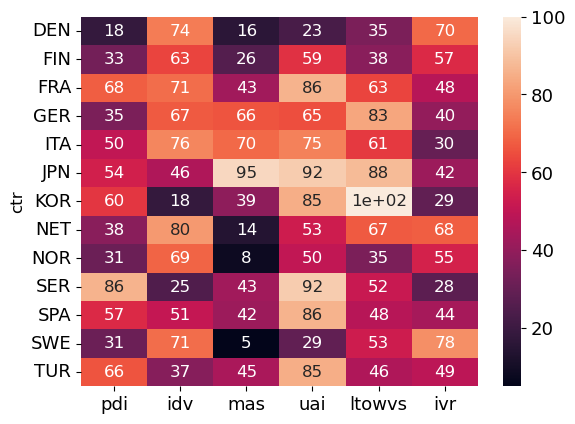

In [180]:
ctr_codes = ["JPN", "KOR", "TUR", "SWE", "NOR", "FIN", "DEN", "SER", "ITA", "SPA", "NET", "FRA", "GER"]
hofstede = pd.read_csv("../data/6-dimensions-for-website-2015-08-16.csv", sep=";")
hofstede = hofstede[hofstede.ctr.isin(ctr_codes)].set_index('ctr').drop('country', axis=1).astype(int)
sns.heatmap(hofstede, annot=True)

In [181]:
dbscan = DBSCAN(eps=6, min_samples=1)
for dim in hofstede.columns:
    hofstede['cluster_' + dim] = dbscan.fit_predict(hofstede[[dim]])
hofstede

,pdi,idv,mas,uai,ltowvs,ivr,cluster_pdi,cluster_idv,cluster_mas,cluster_uai,cluster_ltowvs,cluster_ivr
ctr,,,,,,,,,,,,
DEN,18,74,16,23,35,70,0,0,0,0,0,0
FIN,33,63,26,59,38,57,1,0,1,1,0,1
FRA,68,71,43,86,63,48,2,0,2,2,1,1
GER,35,67,66,65,83,40,1,0,3,1,2,1
ITA,50,76,70,75,61,30,2,0,3,3,1,2
JPN,54,46,95,92,88,42,2,1,4,2,2,1
KOR,60,18,39,85,100,29,2,2,2,2,3,2
NET,38,80,14,53,67,68,1,0,0,1,1,0
NOR,31,69,8,50,35,55,1,0,0,1,0,1


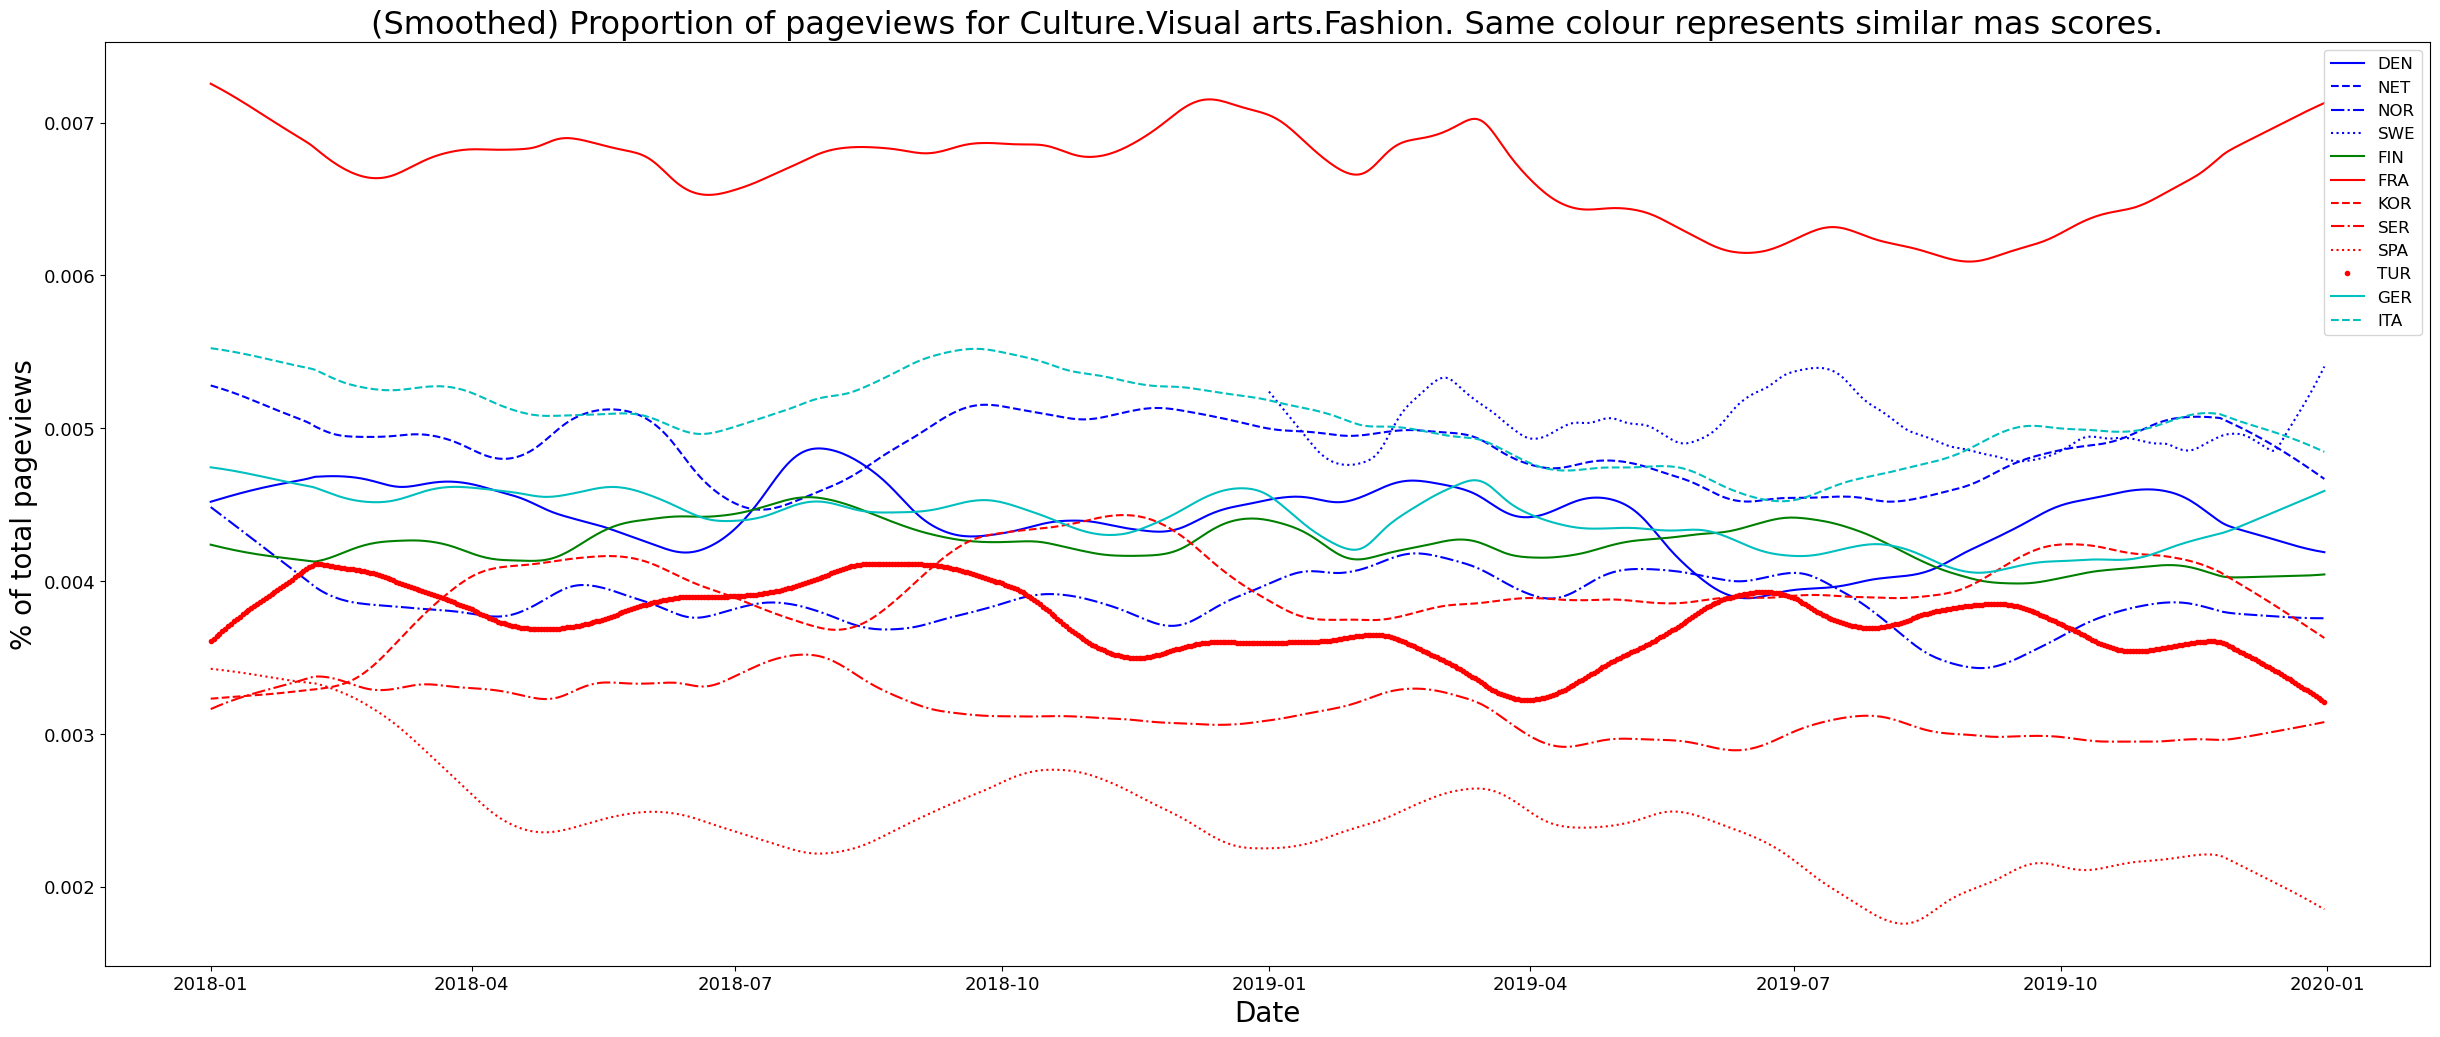

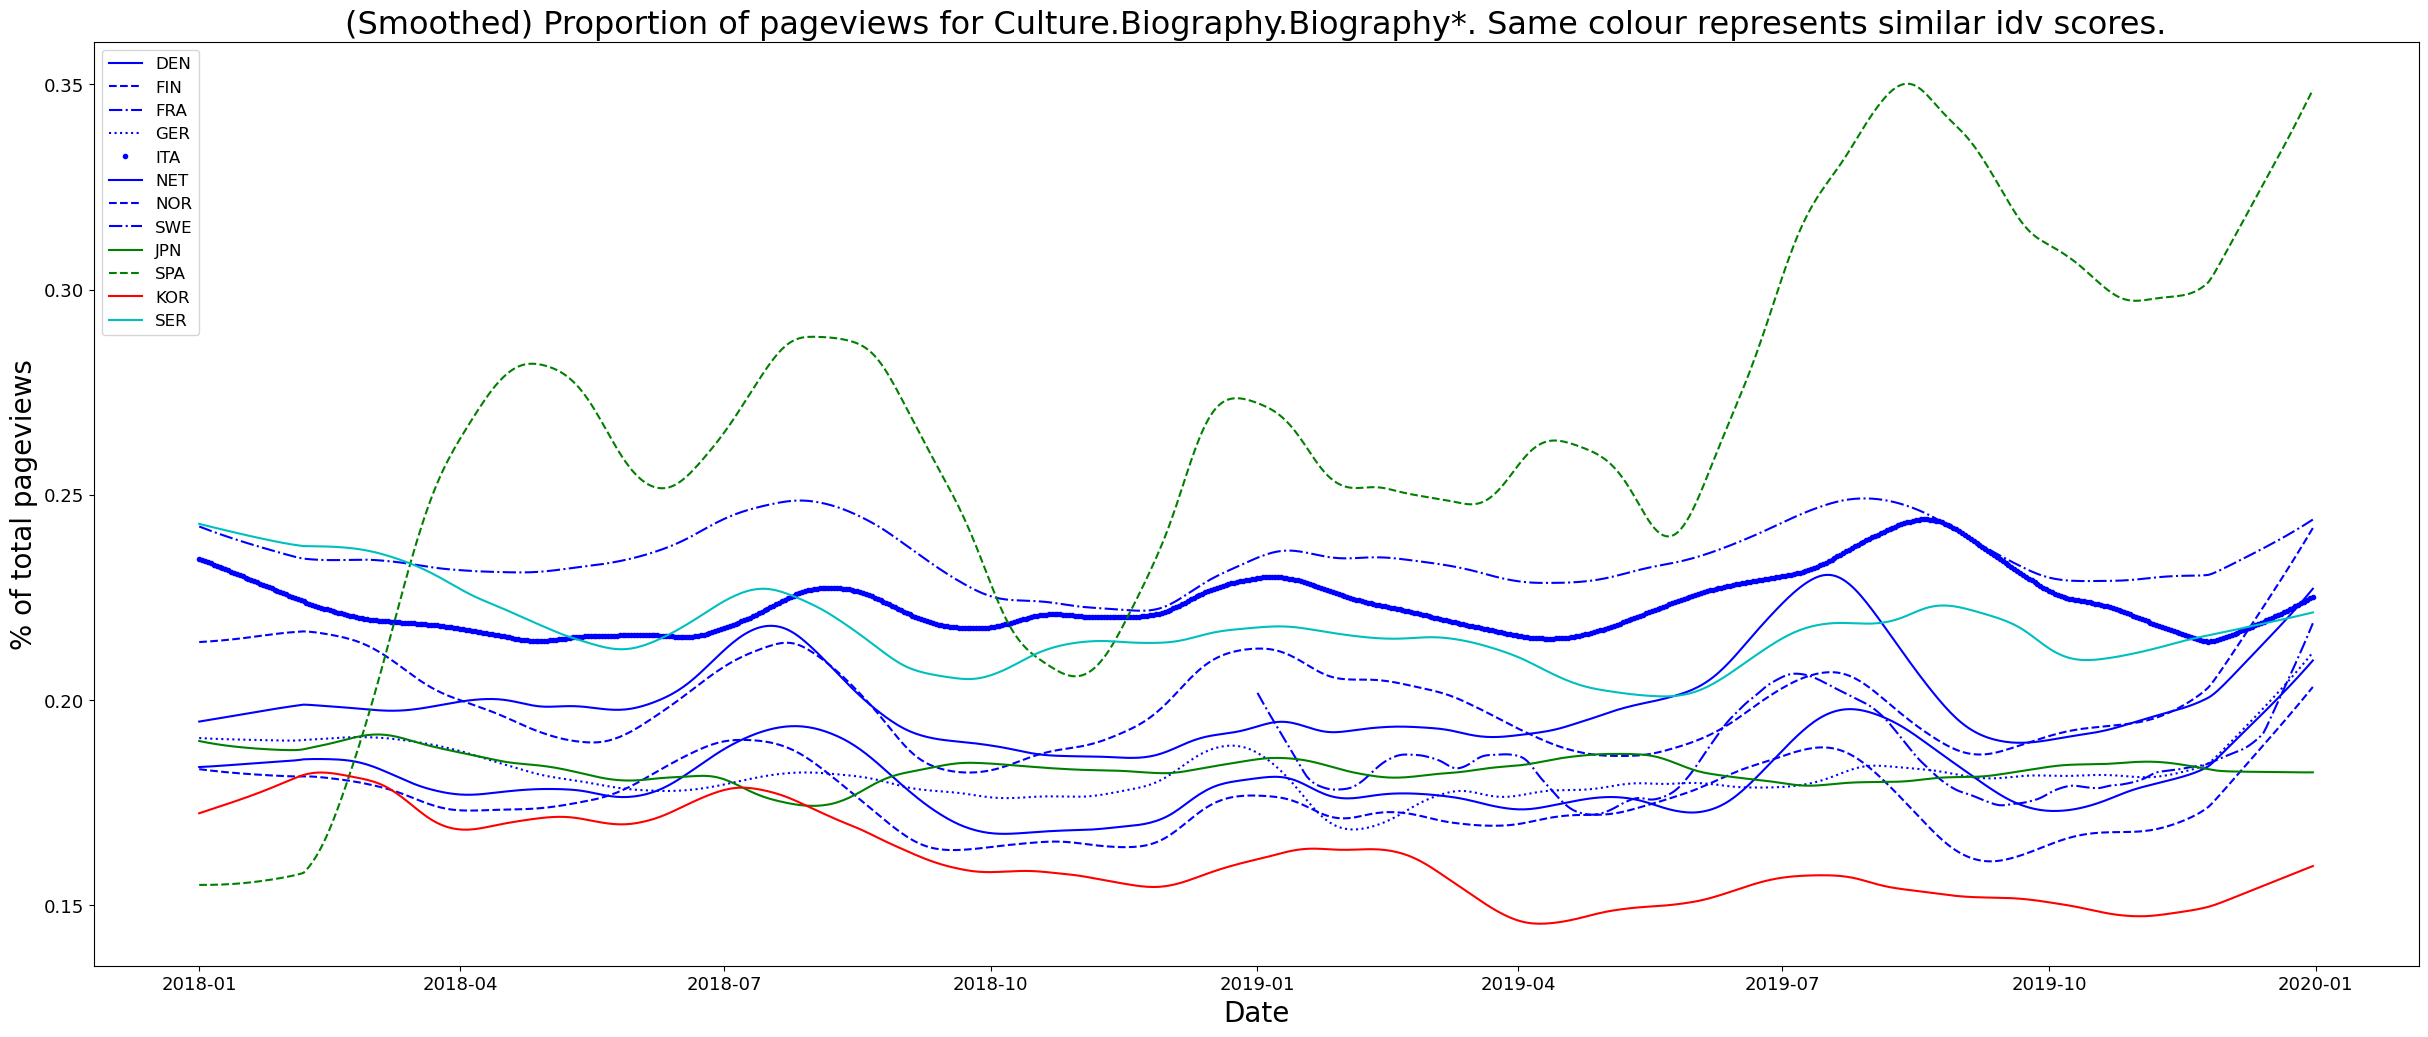

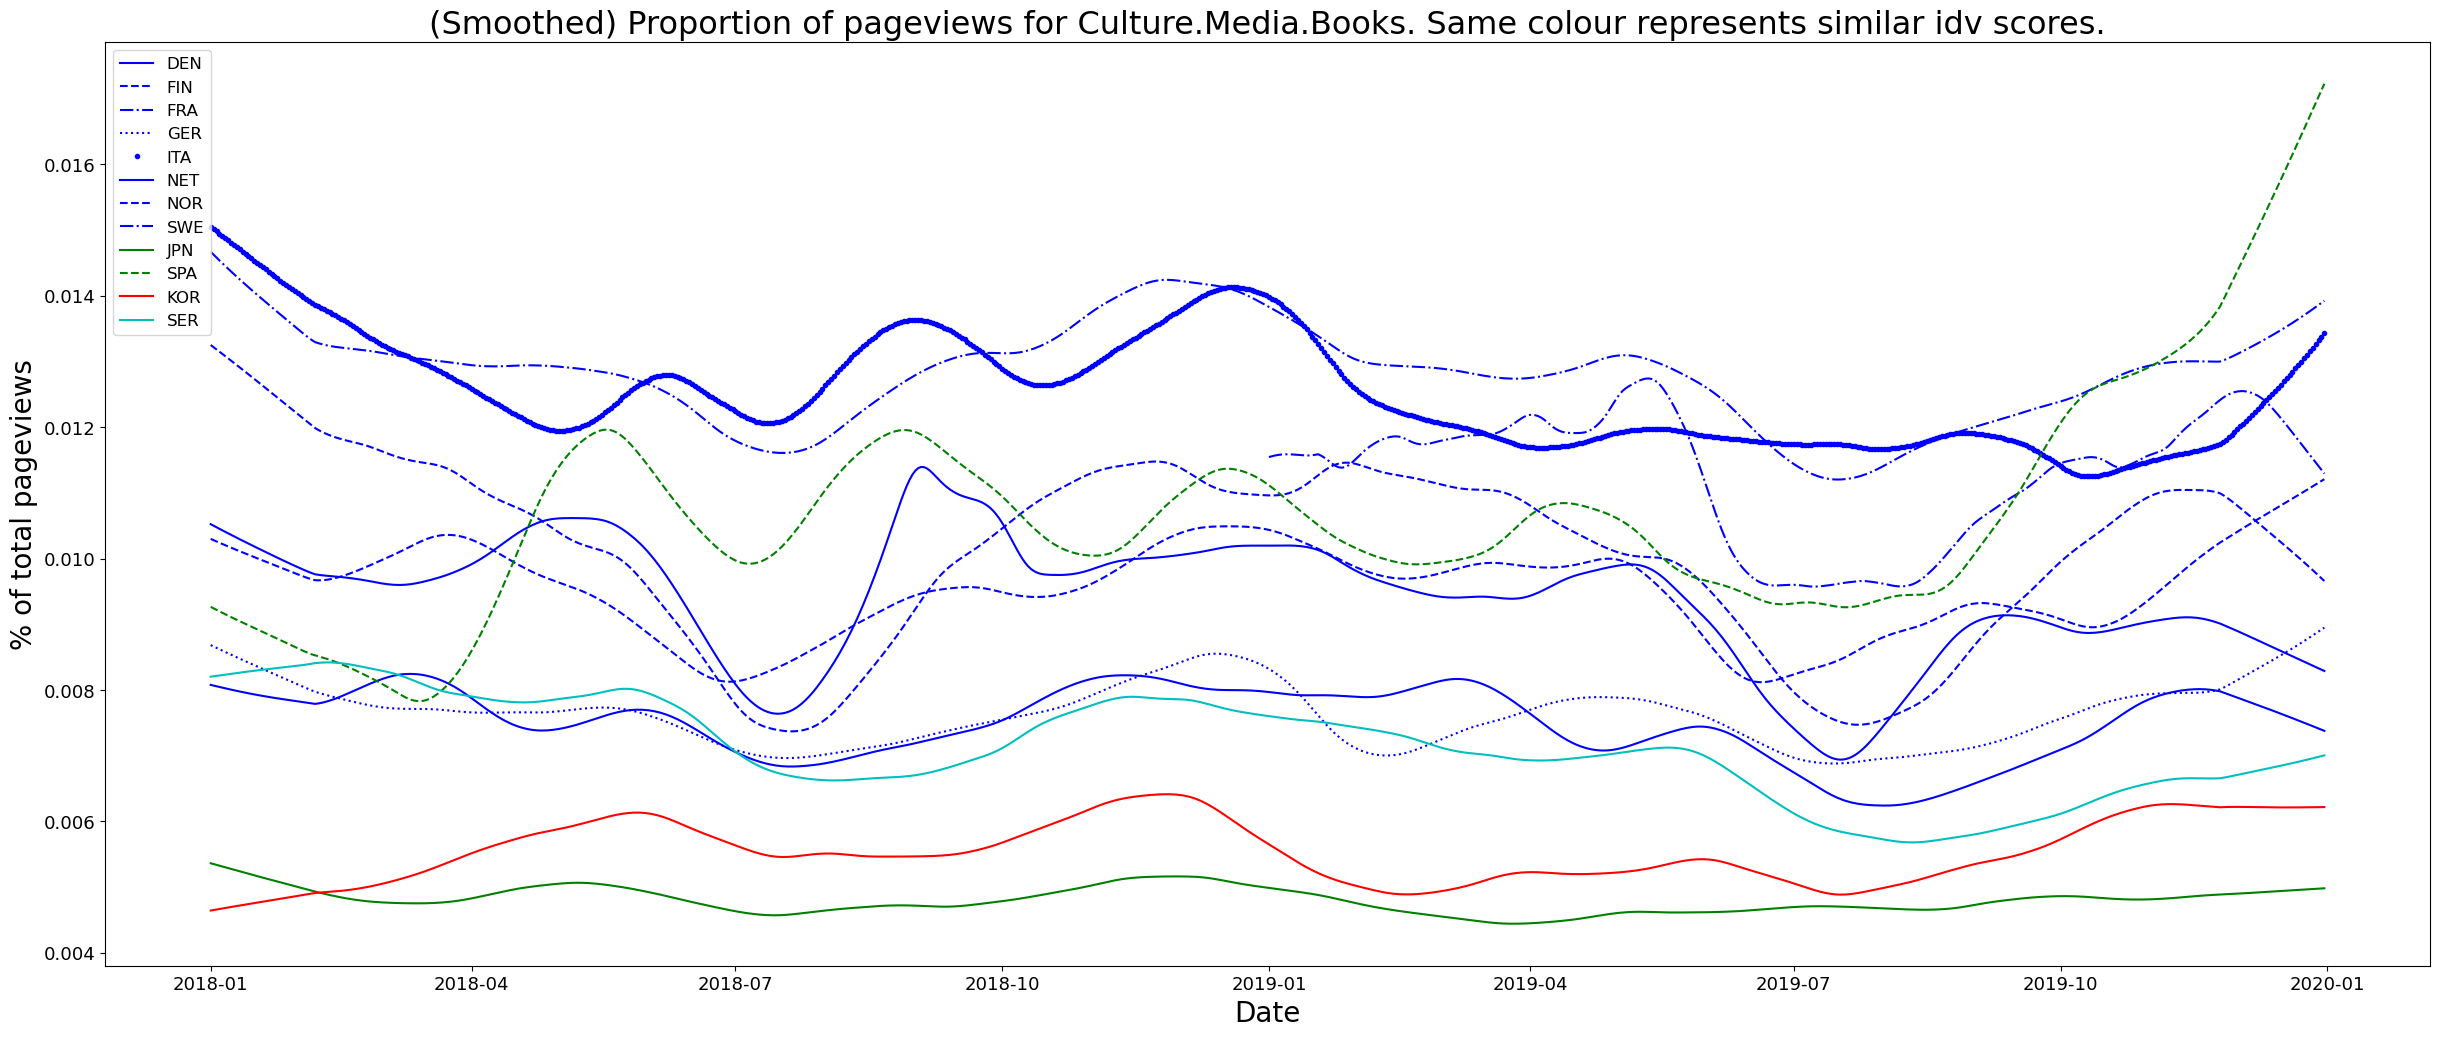

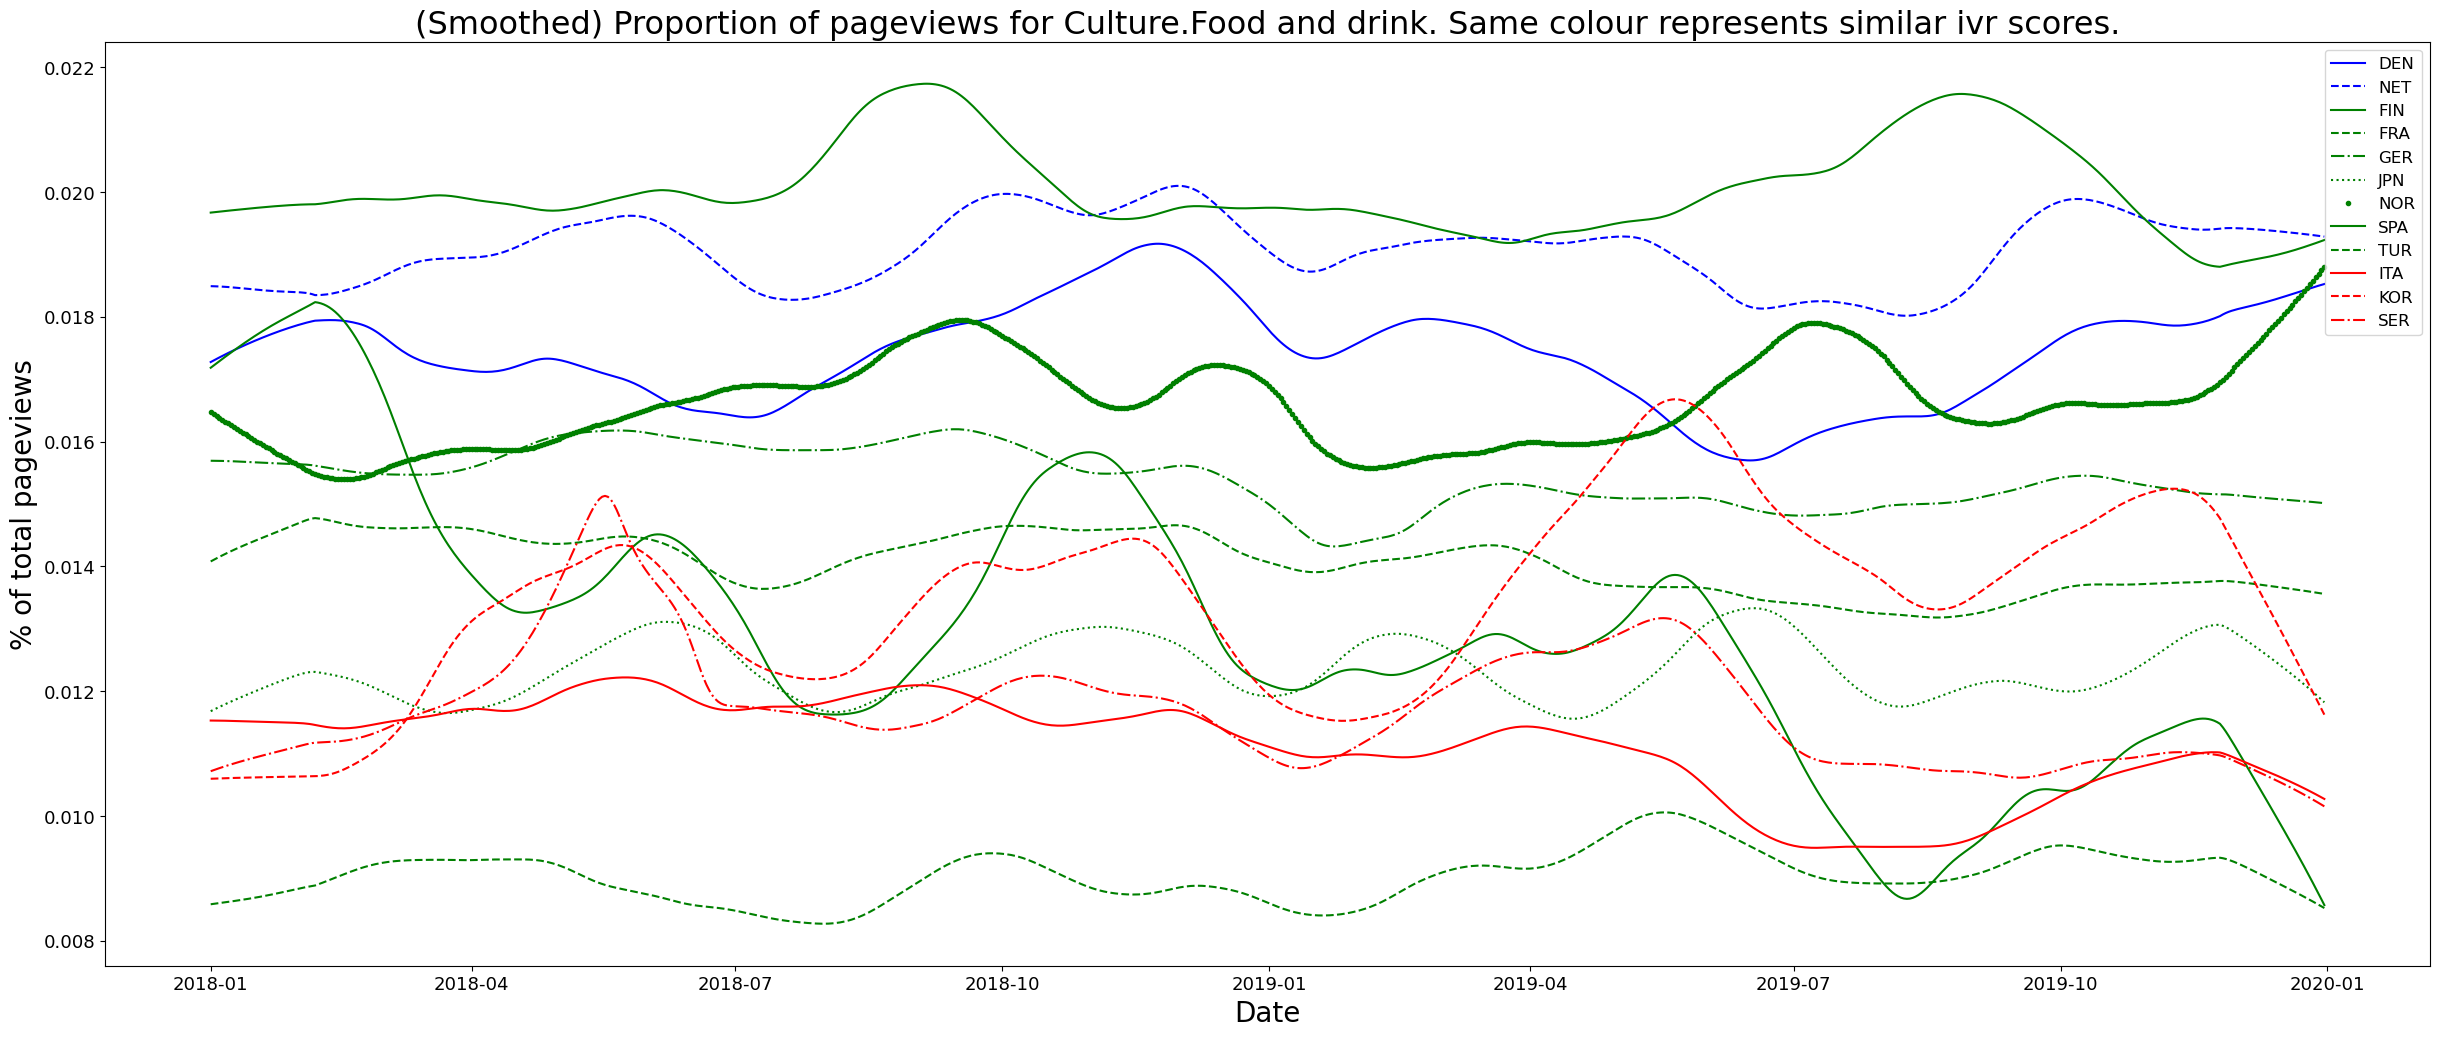

In [187]:
links = {'mas': ['Culture.Visual arts.Fashion'], 
         'idv': ['Culture.Biography.Biography*', 'Culture.Media.Books'], 
         'ivr': ['Culture.Food and drink']}

colors = ['b', 'g', 'r', 'c']
dash = ['-', '--', '-.', ':', '.']
d = len(dash)

for dim, topicz in links.items():
    for t in topicz:
        tdict = {}
        for key in lang_codes:
            series = agg[key]['topics'][t]['sum'] / agg[key]['sum']
            series = series[series.index.year < 2020]
            tdict[key] = series
        
        df = pd.DataFrame.from_dict(tdict)
        _, ax = plt.subplots(figsize=(30,12))
        for i in range(hofstede["cluster_" + dim].max()):
            for j, cty in enumerate(hofstede[hofstede["cluster_" + dim] == i].index):
                code = code_dict[cty]
                smooth = lowess(df[code], df.index, frac=0.1)
                ax.plot(pd.to_datetime(smooth[:,0]), smooth[:,1], colors[i] + dash[j%d], label=cty)
                
        ax.legend()
        ax.set_xlabel('Date', fontsize=20)
        ax.set_ylabel('% of total pageviews', fontsize=20)
        ax.set_title('(Smoothed) Proportion of pageviews for ' + t +'. Same colour represents similar ' + dim + ' scores.', fontsize=23)
plt.show()
